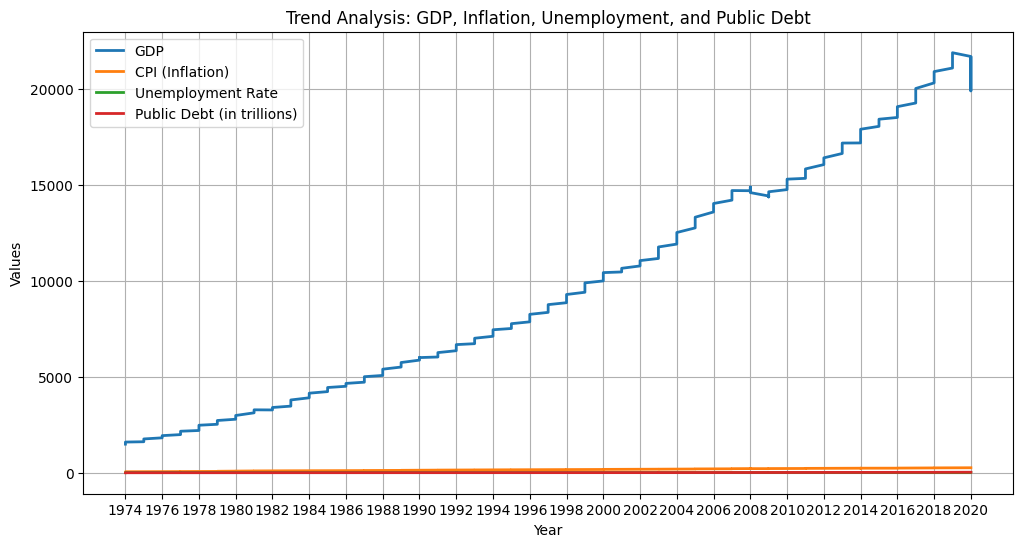

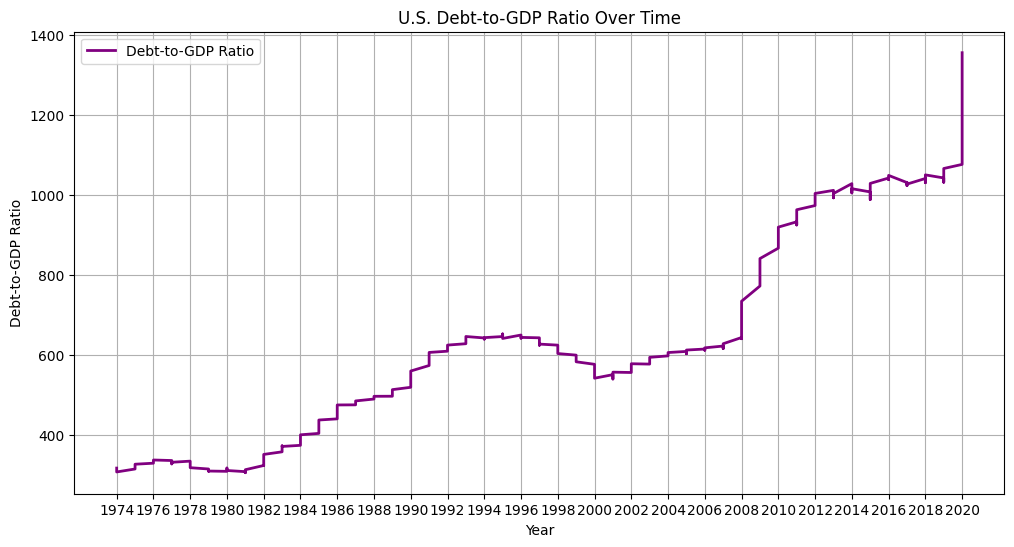

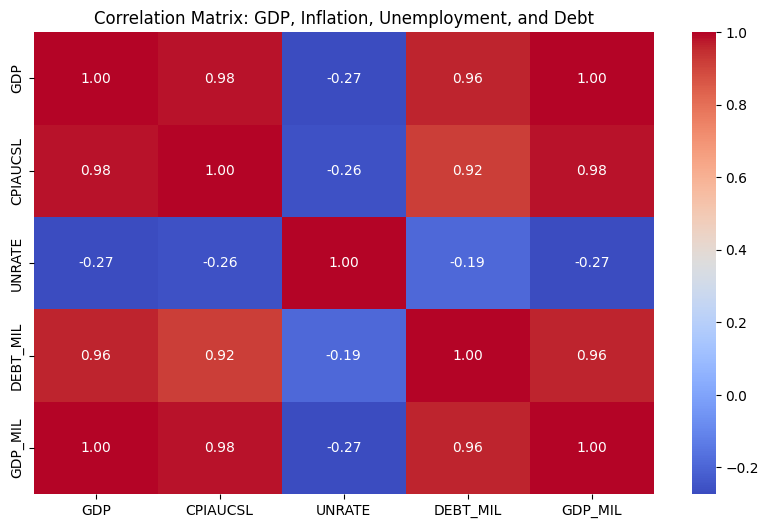

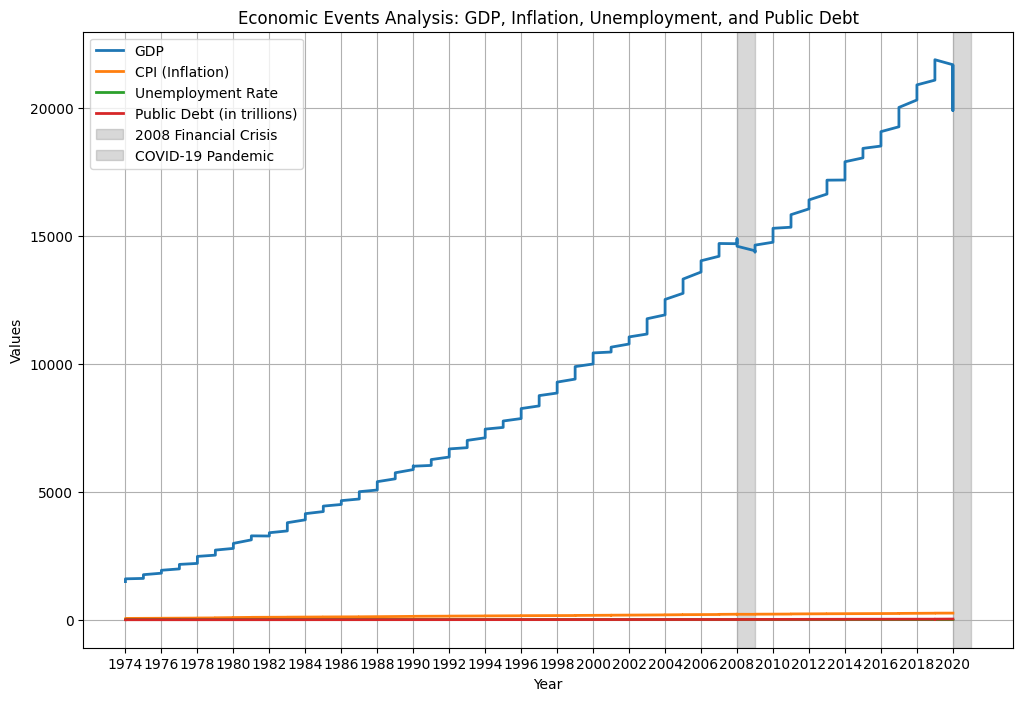

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import os
from kaggle import KaggleApi

# # Instantiate Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download and extract population dataset
# dataset = "thedevastator/u-s-public-debt-vs-gdp-from-1947-2020"
# folder = 'data'
# try:
#     api.dataset_download_files(dataset, path=folder, unzip=True)
# except Exception as e:
#     print(f"Error downloading dataset: {e}")
#     exit(1)

# import os
# from kaggle import KaggleApi

# # Instantiate Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download and extract population dataset
# dataset = "alfredkondoro/u-s-economic-indicators-1974-2024"
# folder = 'data'
# try:
#     api.dataset_download_files(dataset, path=folder, unzip=True)
# except Exception as e:
#     print(f"Error downloading dataset: {e}")
#     exit(1)

# # Step 1: Read and preprocess the datasets
cpi_data = pd.read_csv("data/cpi_data.csv")
gdp_data = pd.read_csv("data/gdp_data.csv")
unemployment_data = pd.read_csv("data/unemployment_data.csv")
us_gdp_debt = pd.read_csv("data/US GDP vs Debt.csv")

# Ensure consistent column names
cpi_data.columns = ["DATE", "CPIAUCSL"]
gdp_data.columns = ["DATE", "GDP"]
unemployment_data.columns = ["DATE", "UNRATE"]
us_gdp_debt.columns = ["index","Quarter", "Gross Domestic Product ($mil)", "Total Public Debt ($mil)"]

# # Step 2 :  Converting Date Columns to Datetime Format
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
us_gdp_debt['Quarter'] = pd.to_datetime(us_gdp_debt['Quarter'])

# # Step 3: Converting Monthly Data to Quarterly Data

# CPI
cpi_data['Quarter'] = cpi_data['DATE'].dt.to_period('Q')
cpi_quarterly = cpi_data.groupby('Quarter')['CPIAUCSL'].mean().reset_index()

# GDP Quarter
gdp_data['Quarter'] = gdp_data['DATE'].dt.to_period('Q')
gdp_quarterly = gdp_data.groupby('Quarter')['GDP'].mean().reset_index()

# unemployment Quarter
unemployment_data['Quarter'] = unemployment_data['DATE'].dt.to_period('Q')
unemployment_quarterly = unemployment_data.groupby('Quarter')['UNRATE'].mean().reset_index()

# # Step 4: Merge the datasets
# Merge CPI, GDP, and Unemployment data on Quarter
merged_quarterly = cpi_quarterly.merge(unemployment_quarterly, on='Quarter', how='inner')
merged_quarterly = merged_quarterly.merge(gdp_quarterly, on='Quarter', how='inner')

# Merge with Debt data
us_gdp_debt.rename(columns={
    'Gross Domestic Product ($mil)': 'GDP_MIL',
    'Total Public Debt ($mil)': 'DEBT_MIL'
}, inplace=True)
us_gdp_debt['Quarter'] = us_gdp_debt['Quarter'].dt.to_period('Q')

# Save the final combined dataset
# final = merged_quarterly.merge(us_gdp_debt, on='Quarter', how='inner')
# final.to_csv("data/final_combined_quarterly_data.csv", index=False)
# print("Final combined dataset saved as 'final_combined_quarterly_data.csv'.")

final_data = pd.read_csv("data/final_combined_quarterly_data.csv")
# # Step 5: Yearly aggregation
final_data['Year'] = final_data['Quarter'].str[:4].astype(int)


annual_data = final_data.groupby('Year').sum().reset_index()

# # Step 6 : Analysys 1 - Trend Analysis
# Explore how GDP, CPI (inflation), unemployment, and public debt change over time.
# Visualize the data with clear line plots to identify trends.

plt.figure(figsize=(12, 6))
plt.plot(final_data['Year'], final_data['GDP'], label='GDP', linewidth=2)
plt.plot(final_data['Year'], final_data['CPIAUCSL'], label='CPI (Inflation)', linewidth=2)
plt.plot(final_data['Year'], final_data['UNRATE'], label='Unemployment Rate', linewidth=2)
plt.plot(final_data['Year'], final_data['DEBT_MIL'] / 1e6, label='Public Debt (in trillions)', linewidth=2)
plt.title("Trend Analysis: GDP, Inflation, Unemployment, and Public Debt")
plt.xlabel("Year")
plt.ylabel("Values")

years = final_data['Year'].unique()
plt.xticks(ticks=years[::2], labels=years[::2])

plt.legend()
plt.grid(True)
plt.show()

# # Step 7 : Analysys 2 - Debt-to-GDP Ratio
# Calculate and analyze the ratio of public debt to GDP.
# Identify periods where borrowing grew faster or slower than GDP.

# Calculate Debt-to-GDP Ratio
final_data['Debt_to_GDP_Ratio'] = final_data['DEBT_MIL'] / final_data['GDP_MIL']

# Plot the Debt-to-GDP Ratio over time
plt.figure(figsize=(12, 6))
plt.plot(final_data['Year'], final_data['Debt_to_GDP_Ratio'], label='Debt-to-GDP Ratio', color='purple', linewidth=2)
plt.title("U.S. Debt-to-GDP Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Debt-to-GDP Ratio")
plt.grid(True)

# Custom x-axis ticks for every 2 years
years = final_data['Year'].unique()
plt.xticks(ticks=years[::2], labels=years[::2])

plt.legend()
plt.show()

# # Step 8 : Analysys 3 - Correlation Analysis:
# Explore relationships between key metrics:
# Unemployment vs. GDP.
# Inflation (CPI) vs. GDP.
# Public Debt vs. GDP Growth.

# Select relevant columns for correlation analysis
correlation_columns = ['GDP', 'CPIAUCSL', 'UNRATE', 'DEBT_MIL', 'GDP_MIL']
correlation_data = final_data[correlation_columns]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix: GDP, Inflation, Unemployment, and Debt")
plt.show()


# # Step 9 : Analysys 4 - Economic Events Analysis:
# Highlight significant periods like recessions (e.g., 2008, 2020).
# Assess their impact on GDP, inflation, unemployment, and debt.

# Define economic events
events = {
    "2008 Financial Crisis": (2008, 2009),
    "COVID-19 Pandemic": (2020, 2021)
}

# Plot key metrics with highlighted events
plt.figure(figsize=(12, 8))

# Plot GDP
plt.plot(final_data['Year'], final_data['GDP'], label='GDP', linewidth=2)

# Plot CPI (Inflation)
plt.plot(final_data['Year'], final_data['CPIAUCSL'], label='CPI (Inflation)', linewidth=2)

# Plot Unemployment
plt.plot(final_data['Year'], final_data['UNRATE'], label='Unemployment Rate', linewidth=2)

# Plot Public Debt
plt.plot(final_data['Year'], final_data['DEBT_MIL'] / 1e6, label='Public Debt (in trillions)', linewidth=2)

# Highlight economic events
for event, (start, end) in events.items():
    plt.axvspan(start, end, color='gray', alpha=0.3, label=f"{event}")

# Customize the chart
plt.title("Economic Events Analysis: GDP, Inflation, Unemployment, and Public Debt")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Custom x-axis ticks for every 2 years
years = final_data['Year'].unique()
plt.xticks(ticks=years[::2], labels=years[::2])

plt.show()

# # # Step 6: Analysis 1 - Trends over time
# plt.figure(figsize=(12, 8))

# # # CPI Trend
# plt.subplot(2, 2, 1)
# plt.plot(annual_data['Year'], annual_data['CPIAUCSL'], label='CPI', marker='o', color='blue')
# plt.title('Trend of CPI over Time (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('CPI')
# plt.xticks(annual_data['Year'][::2], rotation=45)  
# plt.grid(True)

# # # Unemployment Rate Trend
# plt.subplot(2, 2, 2)
# plt.plot(annual_data['Year'], annual_data['UNRATE'], label='Unemployment Rate', marker='o', color='green')
# plt.title('Trend of Unemployment Rate over Time (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('Unemployment Rate (%)')
# plt.xticks(annual_data['Year'][::2], rotation=45)
# plt.grid(True)

# # # GDP Trend
# plt.subplot(2, 2, 3)
# plt.plot(annual_data['Year'], annual_data['GDP_MIL'], label='GDP (Million $)', marker='o', color='orange')
# plt.title('Trend of GDP over Time (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('GDP (Million $)')
# plt.xticks(annual_data['Year'][::2], rotation=45)
# plt.grid(True)

# # # Public Debt Trend
# plt.subplot(2, 2, 4)
# plt.plot(annual_data['Year'], annual_data['DEBT_MIL'], label='Public Debt (Million $)', marker='o', color='red')
# plt.title('Trend of Public Debt over Time (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('Public Debt (Million $)')
# plt.xticks(annual_data['Year'][::2], rotation=45)
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# # # Step 5: Analysis 2 - Correlation matrix
# columns_to_correlate = ['CPIAUCSL', 'UNRATE', 'GDP_MIL', 'DEBT_MIL']
# correlation_matrix = annual_data[columns_to_correlate].corr()

# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Economic Indicators')
# plt.show()

# # Step 6: Analysis 3 - Public Debt as a Percentage of GDP
# annual_data['Debt_to_GDP_Ratio'] = (annual_data['DEBT_MIL'] / annual_data['GDP_MIL']) * 100
# plt.figure(figsize=(10, 6))
# plt.plot(annual_data['Year'], annual_data['Debt_to_GDP_Ratio'], marker='o', color='purple', label='Debt-to-GDP Ratio')
# plt.title('Debt-to-GDP Ratio Over Time (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('Debt-to-GDP Ratio (%)')
# plt.xticks(annual_data['Year'][::2], rotation=45)  # تنظیم فاصله محور x برای نمایش هر 2 سال یک بار
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined dataset
final_data = pd.read_csv("data/final_combined_quarterly_data.csv")

# Extract 'Year' and ensure it's integer for comparisons
final_data['Year'] = final_data['Quarter'].str[:4].astype(int)

# Define economic events
events = {
    "2008 Financial Crisis": (2008, 2009),
    "COVID-19 Pandemic": (2020, 2021)
}

# Plot key metrics with highlighted events
plt.figure(figsize=(12, 8))

# Plot GDP
plt.plot(final_data['Year'], final_data['GDP'], label='GDP', linewidth=2)

# Plot CPI (Inflation)
plt.plot(final_data['Year'], final_data['CPIAUCSL'], label='CPI (Inflation)', linewidth=2)

# Plot Unemployment
plt.plot(final_data['Year'], final_data['UNRATE'], label='Unemployment Rate', linewidth=2)

# Plot Public Debt
plt.plot(final_data['Year'], final_data['DEBT_MIL'] / 1e6, label='Public Debt (in trillions)', linewidth=2)

# Highlight economic events
for event, (start, end) in events.items():
    plt.axvspan(start, end, color='gray', alpha=0.3, label=f"{event}")

# Customize the chart
plt.title("Economic Events Analysis: GDP, Inflation, Unemployment, and Public Debt")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Custom x-axis ticks for every 2 years
years = final_data['Year'].unique()
plt.xticks(ticks=years[::2], labels=years[::2])

plt.show()
